In [1]:
import glob
import re
import numpy as np
import nibabel as nib
from pathlib import Path

import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

from src import custom_plotting as cp
from nilearn import surface, datasets
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def filter_r(rs, ps, p_crit=0.05, correct=True, threshold=True):
    if correct and (ps is not None):
        _, ps_corrected, _, _ = multipletests(ps, method='fdr_bh')
    else:
        ps_corrected = ps.copy()

    if threshold and (ps is not None):
        rs[ps_corrected >= p_crit] = 0.
    else:
        rs[rs < 0.] = 0.
    return rs, ps_corrected

In [3]:
def load_roi_stats(loc_dir, mask, sid, task, afni_label):
    # Load ROI stats
    brik = nib.load(f'{loc_dir}/sub-{sid}.{task}.results/stats.sub-{sid}.{task}+tlrc.BRIK')
    labels = brik.header.get_volume_labels()
    loc = np.array(brik.dataobj)[..., labels.index(afni_label)].flatten()
    loc = loc[mask]

    #Filter to the significant voxels
    loc[loc < stats.norm.isf(0.01)] = 0.
    loc[loc < 0] = 0.

    # Make binary
    loc[loc != 0] = 1.
    loc = loc.astype('bool')
    return np.invert(loc)

In [4]:
process = 'PlotVoxelBetas'
n_subjs = 4
method = 'test'
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis'
data_dir = f'{top_dir}/data/raw'
out_dir = f'{top_dir}/data/interim'
figure_dir = f'{top_dir}/reports/figures/{process}'
Path(figure_dir).mkdir(parents=True, exist_ok=True)
fsaverage = datasets.fetch_surf_fsaverage()
roi_parcel = None
cmap = sns.color_palette("icefire", as_cmap=True)

mask_im = nib.load(f'{out_dir}/Reliability/sub-all_set-test_stat-rho_statmap.nii.gz')
mask = np.load(f'{out_dir}/Reliability/sub-all_set-test_reliability-mask.npy').astype('bool')
features = pd.read_csv(f'{data_dir}/annotations/annotations.csv').sort_values(by=['video_name']).drop(columns=['video_name']).columns.to_numpy()

In [5]:
loc_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis/data/raw/localizer_stats'
tasks = ['unfiltered']#, 'tom', 'SIpSTS']
afni_labels = [None]#, 'Belief-Photo_GLT#0_Tstat', 'Interact-Non_GLT#0_Tstat']

sub-all
unfiltered: indoor
unfiltered: expanse
unfiltered: transitivity
unfiltered: agent distance
unfiltered: facingness
unfiltered: joint action
unfiltered: communication
unfiltered: cooperation
unfiltered: dominance
unfiltered: intimacy
unfiltered: valence
unfiltered: arousal
sub-01
unfiltered: indoor
unfiltered: expanse
unfiltered: transitivity
unfiltered: agent distance
unfiltered: facingness
unfiltered: joint action
unfiltered: communication
unfiltered: cooperation
unfiltered: dominance



KeyboardInterrupt



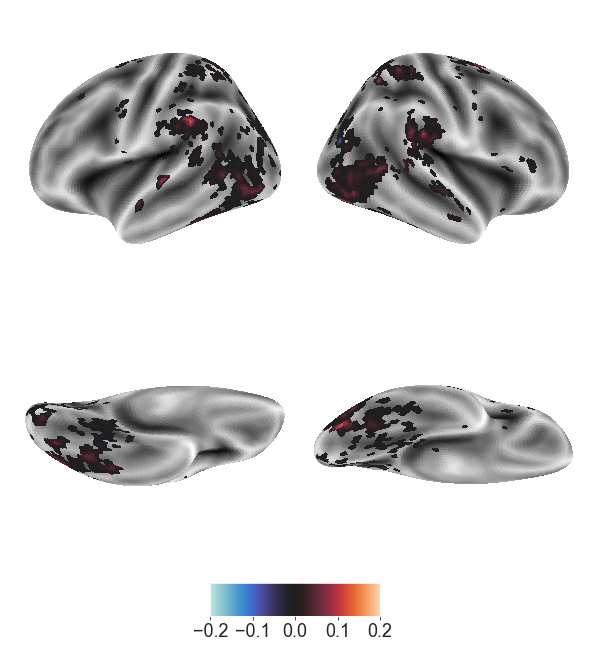

In [6]:
for sid in ['all', '01', '02', '03', '04']:
    print(f'sub-{sid}')

    betas = np.load(f'{out_dir}/VoxelRegression/sub-{sid}_betas_method-{method}.npy')
    ps = np.load(f'{out_dir}/VoxelPermutation/sub-{sid}_prediction-all_method-{method}_ps.npy')

    for task, afni_label in zip(tasks, afni_labels):
        for i_feature, feature in enumerate(features):
            print(f'{task}: {feature}')
            Path(f'{figure_dir}/{task}/{feature}').mkdir(parents=True, exist_ok=True)

            volume = betas[i_feature, :]
            volume, _ = filter_r(volume, ps)

            if afni_label is not None:
                loc = load_roi_stats(loc_dir, mask, sid, task, afni_label)
                volume[loc] = 0.

            volume = cp.mkNifti(volume, mask, mask_im)
            texture = {'left': surface.vol_to_surf(volume, fsaverage['pial_left'],
                                                   interpolation='nearest'),
                       'right': surface.vol_to_surf(volume, fsaverage['pial_right'],
                                                    interpolation='nearest')}

            vmax = np.nanmax(texture['right'])
            cp.plot_betas(fsaverage, texture,
                          roi=roi_parcel,
                          cmap=cmap,
                          modes=['lateral', 'ventral'],
                          threshold=1e-7,
                          output_file=f'{figure_dir}/{task}/{feature}/sub-{sid}.png')